In [1]:
# Import the data
import json
import os
data_folder = os.path.join(os.getcwd(), "job_data", "indeed_jds_by_doc.json")
indeed = json.load(open(data_folder, "r"))

In [2]:
# Explore the data
import re
job_list = indeed['job_descriptions']
for index, string_with_matchword in enumerate(re.findall('.{20}communicat.{20}', job_list[0].lower())):
    print(''.join([str(index),': ', string_with_matchword]))

0: ng, maintenance and communication of logical and p
1: le for creation and communication of data architec
2: es, development and communication of best practice
3:  verbal and written communication skills and exper


In [3]:
# Tokenize with nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Stemming
from nltk.stem import WordNetLemmatizer, PorterStemmer
stemmer = PorterStemmer()

# Lemmatization
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Stop word
from nltk.corpus import stopwords
en_sw = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\57luu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\57luu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Create bag of words COUNT with customized sklearn
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=en_sw, tokenizer=word_tokenize)
analyzer = vectorizer.build_analyzer()

def stem_analyzer(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]

stem_vectorizer = CountVectorizer(analyzer=stem_analyzer)
bow_skl = stem_vectorizer.fit_transform(indeed["job_descriptions"])
freq_skl = bow_skl.toarray()
feature_name = stem_vectorizer.get_feature_names()

C:\Users\57luu\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
# Explore the top words by counts
import numpy as np
word_name = feature_name
word_count = np.sum(freq_skl, axis=0)
index_sort = np.argsort(word_count)
top_index = index_sort[-30:]
top_word = [word_name[ind] for ind in top_index[::-1]]
print(top_word)

[',', '.', ':', 'work', 'experi', 'data', ')', '(', 'manag', 'team', 'develop', 'requir', 'product', '’', 'design', 'busi', 'year', 'includ', 'new', '--', 'commun', 'skill', 'engin', ';', 'compani', 'support', 'applic', 'build', 'use', 'process']


In [12]:
# Create bag of words TFIDF with customized sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer=stem_analyzer)
tfidf_skl = tfidf_vectorizer.fit_transform(indeed['job_descriptions'])
tokens = tfidf_vectorizer.get_feature_names()

In [17]:
# Explore the top words by tfidf
import numpy as np
word_name = tokens
word_count = np.sum(tfidf_skl.toarray(), axis=0)
index_sort = np.argsort(word_count)
top_index = index_sort[-30:]
top_word = [word_name[ind] for ind in top_index[::-1]]
print(top_word)

[',', '.', ':', 'data', 'work', 'experi', ')', '(', 'manag', 'team', 'product', 'develop', 'design', '’', 'busi', 'requir', '--', 'engin', ';', 'year', 'skill', 'new', 'includ', 'project', 'compani', 'test', 'commun', 'build', 'applic', 'market']


In [30]:
############## Preprocess the data ##############
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extract training and testing dataset
feature_mat = tfidf_skl.toarray()
le = preprocessing.LabelEncoder()
le.fit(list(set(indeed['labels'])))
target_encode = le.transform(indeed['labels'])

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(feature_mat, target_encode, random_state=0)

# Scale the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Check the encoding
print(set(indeed['labels']))
for label, code in zip(indeed['labels'][100:120], target_encode[100:120]):
    print("{}: {}".format(label, code))

In [31]:
# Fit random forest
from sklearn.ensemble import RandomForestClassifier
random_cf = RandomForestClassifier(n_estimators=100, n_jobs=8)
random_cf.fit(X_train_scaled, y_train)

# Find the score
random_cf.score(X_test_scaled, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [64]:
# Try grid search on random forest
from sklearn.model_selection import GridSearchCV

n_estimators = [350, 400, 450]
max_depth = [30, 35, 40, 45]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, cv=10, n_jobs=8, verbose=5)
grid.fit(np.concatenate((X_train_scaled, X_test_scaled), axis=0), np.concatenate((y_train, y_test), axis=0))


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   56.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  8.0min
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed: 18.1min finished
C:\Users\57luu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'max

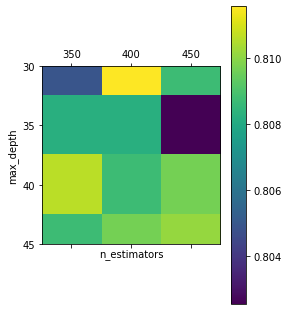

In [65]:
from matplotlib import pyplot as plt
scores = grid.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(max_depth), len(n_estimators))

plt.matshow(scores)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.yticks(np.arange(len(max_depth)), param_grid['max_depth'])
plt.xticks(np.arange(len(n_estimators)), param_grid['n_estimators'])
plt.show()

In [66]:
scores

array([[0.80493593, 0.81158045, 0.8087328 ],
       [0.80825819, 0.80825819, 0.80256289],
       [0.81063123, 0.8087328 , 0.80968201],
       [0.8087328 , 0.80968201, 0.81015662]])

In [81]:
# Fit logistic regression
from sklearn.linear_model import LogisticRegression
lr_cf = LogisticRegression(multi_class='multinomial', n_jobs=8, solver='lbfgs', verbose=5, C=0.1)
lr_cf.fit(X_train_scaled, y_train)

# Find the score
lr_cf.score(X_test_scaled, y_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 12.9min finished


0.6869070208728653

In [69]:
# Try grid search on logistic regression
inverse_regularization = [0.1, 1, 10]

param_grid = {'C': inverse_regularization}
grid = GridSearchCV(LogisticRegression(random_state=0), param_grid=param_grid, cv=10, n_jobs=8, verbose=5)
grid.fit(np.concatenate((X_train_scaled, X_test_scaled), axis=0), np.concatenate((y_train, y_test), axis=0))


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 52.0min
[Parallel(n_jobs=8)]: Done  22 out of  30 | elapsed: 179.4min remaining: 65.2min
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 220.9min finished
C:\Users\57luu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\57luu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\57luu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warnin

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=8, param_grid={'C': [350, 400, 450]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [ ]:
plt.figure(figsize=(10, 10))
ind_x = range(len(inverse_regularization))
plt.plot(ind_x, grid.cv_results_['mean_test_score'])
plt.xticks(ind_x, param_grid['C'])
plt.xlabel('Inverse regularization')
plt.ylabel('Mean test score')
plt.show()

In [72]:
# Fit Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb_cf = MultinomialNB()
mnb_cf.fit(X_train, y_train)

# Find the score
mnb_cf.score(X_test, y_test)

0.6129032258064516

In [77]:
# Try grid search on Naive Bayes
alpha = [0.1, 1, 10]
use_prior = ['True', 'False']
param_grid = {'alpha': alpha, 'fit_prior': use_prior}
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=10, n_jobs=8, verbose=5)
grid.fit(np.concatenate((X_train, X_test), axis=0), np.concatenate((y_train, y_test), axis=0))


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  58 out of  60 | elapsed:   20.0s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:   20.1s finished
C:\Users\57luu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=8,
             param_grid={'alpha': [0.1, 1, 10], 'fit_prior': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

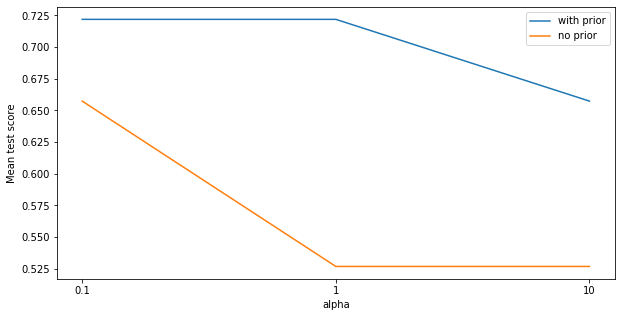

In [80]:
score_mnb = np.reshape(grid.cv_results_['mean_test_score'], (2, len(alpha)))
plt.figure(figsize=(10, 5))
ind_x = range(len(alpha))
plt.plot(ind_x, score_mnb[0, :], label='with prior')
plt.plot(ind_x, score_mnb[1, :], label='no prior')
plt.xticks(ind_x, alpha)
plt.xlabel('alpha')
plt.ylabel('Mean test score')
plt.legend()
plt.show()

In [83]:
# Fit SVM
from sklearn import svm
svm_cf = svm.SVC(decision_function_shape='ovr', n_jobs=6)
svm_cf.fit(X_train_scaled, y_train)

# Find the score
svm_cf.score(X_test_scaled, y_test)

C:\Users\57luu\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5616698292220114